In [1]:
print("test check done!!!")

test check done!!!


In [2]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\bhagy\Development\automated-research-generator


In [3]:
from research_and_analysis.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2026-02-01T12:59:06.220701Z", "level": "info", "event": "Initializing ApiKeyManager"}
{"timestamp": "2026-02-01T12:59:06.221690Z", "level": "info", "event": "OPENAI_API_KEY loaded successfully from environment"}
{"timestamp": "2026-02-01T12:59:06.222840Z", "level": "info", "event": "GOOGLE_API_KEY loaded successfully from environment"}
{"timestamp": "2026-02-01T12:59:06.223848Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"path": "C:\\Users\\bhagy\\Development\\automated-research-generator\\research_and_analysis\\config\\configuration.yaml", "keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-02-01T12:59:06.227848Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-02-01T12:59:06.228855Z", "level": "info", "event": "YAML configuration loaded successfully"}


In [5]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2026-02-01T12:59:10.577858Z", "level": "info", "event": "Loading LLM"}
{"provider": "openai", "model": "gpt-4o", "timestamp": "2026-02-01T12:59:11.484691Z", "level": "info", "event": "LLM loaded successfully"}


In [6]:
llm.invoke("Hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [87]:
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [9]:
from IPython.display import Image, display

In [10]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    role: str = Field(description="Role of the analyst")
    affiliation: str = Field(description="Primary affiliation of the analyst")
    description:str = Field(description="Area of expertise and background of the analyst")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nExpertise: {self.description}\n"

In [11]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations")

In [12]:
class GenerateAnalystState(TypedDict):
    topic: str #research topic
    max_analysts: int #maximum number of analysts to create
    human_analyst_feedback: str #feedback from human analyst
    analysts: List[Analyst] #Analyst asking questions

In [13]:
analyst_instructions = """
You are tasked with creating a set of AI analyst personas. Follow the instructions carefully:

1. First, review the research topic provided:
{topic}

2. Examine any editorial feedback that has been optionally provided tp guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and/or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst persona to each theme, ensuring diversity in roles, affiliations, and expertise.
"""

In [30]:
print(analyst_instructions.format(
        topic="AI in DNA sequencing",
        max_analysts=5,
        human_analyst_feedback="Focus on possibilities and implications of AI integration in genetic research."
    ))


You are tasked with creating a set of AI analyst personas. Follow the instructions carefully:

1. First, review the research topic provided:
AI in DNA sequencing

2. Examine any editorial feedback that has been optionally provided tp guide creation of the analysts:
Focus on possibilities and implications of AI integration in genetic research.

3. Determine the most interesting themes based upon documents and/or feedback above.

4. Pick the top 5 themes.

5. Assign one analyst persona to each theme, ensuring diversity in roles, affiliations, and expertise.



In [38]:
def create_analyst(state: GenerateAnalystState):
    """
    Creates analysts based on the research topic and requirements.
    Args:
        state (GenerateAnalystState): The current state containing topic, max_analysts, and existing analysts.
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )
    
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)] + [
        HumanMessage(content=f"Generate the set of analysts.")])
    
    #writing the list of analysts to state
    return {"analysts": analysts.analysts}
    
    

In [39]:
create_analyst(
    {'topic': 'AI in DNA sequencing',
    'max_analysts': 3,
    'human_analyst_feedback': 'Focus on possibilities and implications of AI integration in genetic research.'
    }
)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Genomics Research Scientist', affiliation='National Institute of Health', description='Dr. Chen specializes in the integration of AI technologies in genomics. Her research focuses on how AI can enhance the accuracy and speed of DNA sequencing, potentially revolutionizing personalized medicine.'),
  Analyst(name='Dr. Raj Patel', role='AI Ethics and Policy Expert', affiliation='Center for AI Policy and Ethics', description="Dr. Patel's expertise lies in the ethical implications of AI in genetic research. He explores the societal impacts, privacy concerns, and regulatory frameworks necessary to ensure responsible use of AI in DNA sequencing."),
  Analyst(name='Dr. Lisa Gomez', role='Biotech Entrepreneur', affiliation='GenAI Innovations', description='Dr. Gomez is a pioneer in biotech startups, focusing on commercial applications of AI in genetic research. She is particularly interested in how AI-driven DNA sequencing can lead to new busin

In [40]:
def human_feedback(state):
    """No output node that should be interrupted on.
    """
    pass

In [171]:
def should_continue(state):
    """Return the next node to execute.
    """
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"
    

In [172]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analysts"
    return END

In [42]:
builder = StateGraph(GenerateAnalystState)

In [43]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [44]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                              should_continue,
                              ["create_analyst",
                               END])

In [45]:
memory = MemorySaver()

In [46]:
graph = builder.compile(interrupt_before=["human_feedback"],
                checkpointer = memory)

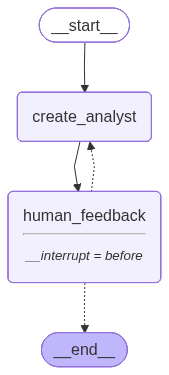

In [47]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [48]:
topic = "AI in Cognitive science"
max_analysts = 4
thread = {"configurable":{"thread_id":2}}

In [49]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts},
             thread,
             stream_mode="values"):
    analysts = event.get("analysts", "")
    
    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("*"*50)
    

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Role: Cognitive Scientist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen specializes in the intersection of AI and human cognition, focusing on how AI can model and enhance human cognitive processes. Her research includes studying neural networks and their ability to simulate human thought patterns.

**************************************************
Name: Professor Alan Thompson
Role: AI Ethicist
Affiliation: Oxford Internet Institute
Expertise: Professor Thompson's expertise lies in the ethical implications of AI in cognitive science. He explores the moral considerations of using AI to influence or replicate human cognition, ensuring that advancements respect human rights and privacy.

**************************************************
Name: Dr. Priya Natarajan
Role: Neuroscientist
Affiliation: Massachusetts Institute of Technology
Expertise: Dr. Natarajan's work involves using AI to decode brain activity and understand cognitive functions. S

In [51]:
state = graph.get_state(thread)

In [52]:
state

StateSnapshot(values={'topic': 'AI in Cognitive science', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='Cognitive Scientist', affiliation='University of California, Berkeley', description='Dr. Chen specializes in the intersection of AI and human cognition, focusing on how AI can model and enhance human cognitive processes. Her research includes studying neural networks and their ability to simulate human thought patterns.'), Analyst(name='Professor Alan Thompson', role='AI Ethicist', affiliation='Oxford Internet Institute', description="Professor Thompson's expertise lies in the ethical implications of AI in cognitive science. He explores the moral considerations of using AI to influence or replicate human cognition, ensuring that advancements respect human rights and privacy."), Analyst(name='Dr. Priya Natarajan', role='Neuroscientist', affiliation='Massachusetts Institute of Technology', description="Dr. Natarajan's work involves using AI to decode brain activi

In [53]:
state.next

('human_feedback',)

In [54]:
graph.update_state(
    thread,
    {"human_analyst_feedback": "Add something from start-up perspective and focus on a latest start-up that has developed a product in this space."},
    as_node="human_feedback"
)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f105b92-7dc9-6e11-8002-c73c8e3f628d'}}

In [55]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts},
             thread,
             stream_mode="values"):
    analysts = event.get("analysts", "")
    
    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("*"*50)

Name: Dr. Emily Chen
Role: Cognitive Scientist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen specializes in the intersection of AI and human cognition, focusing on how AI can model and enhance human cognitive processes. Her research includes studying neural networks and their ability to simulate human thought patterns.

**************************************************
Name: Professor Alan Thompson
Role: AI Ethicist
Affiliation: Oxford Internet Institute
Expertise: Professor Thompson's expertise lies in the ethical implications of AI in cognitive science. He explores the moral considerations of using AI to influence or replicate human cognition, ensuring that advancements respect human rights and privacy.

**************************************************
Name: Dr. Priya Natarajan
Role: Neuroscientist
Affiliation: Massachusetts Institute of Technology
Expertise: Dr. Natarajan's work involves using AI to decode brain activity and understand cognitive functions. S

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Role: Cognitive Scientist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen is a leading cognitive scientist with a focus on the intersection of AI and human cognition. Her research explores how AI can model and enhance cognitive processes, and she has published extensively on machine learning applications in cognitive science.

**************************************************
Name: Raj Patel
Role: AI Start-up Founder
Affiliation: NeuroAI Innovations
Expertise: Raj is the founder of NeuroAI Innovations, a start-up that recently launched a groundbreaking AI-driven cognitive enhancement tool. With a background in computer science and entrepreneurship, Raj focuses on developing AI products that improve cognitive functions such as memory and attention.

**************************************************
Name: Dr. Sophia Martinez
Role: Neuroscientist
Affiliation: MIT Media Lab
Expertise: Dr. Martinez is a neuroscientist at MIT Media Lab, where she in

In [61]:
state = graph.get_state(thread)

In [63]:
cfg = state.config

In [64]:
graph.update_state(
    cfg,
    {"human_analyst_feedback": ""},
    as_node="human_feedback"
)

KeyError: None

In [65]:
state.next

('create_analyst',)

### Second Workflow

In [79]:
from dotenv import load_dotenv
load_dotenv()

True

In [83]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [82]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="Artificial Intelligence").load()
print(docs[0].page_content[:500])

Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.
High-profile applications of AI incl


In [84]:
tavily_search = TavilySearchResults(api_key=tavily_api_key)

C:\Users\bhagy\AppData\Local\Temp\ipykernel_26404\4082919888.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(api_key=tavily_api_key)


In [85]:
tavily_search.invoke("What are the latest trends in AI research?")

[{'title': "What's next in AI: 7 trends to watch in 2026",
  'url': 'https://news.microsoft.com/source/features/ai/whats-next-in-ai-7-trends-to-watch-in-2026/',
  'content': 'What’s different now is the rise of hybrid computing, where quantum works alongside AI and supercomputers. AI finds patterns in data. Supercomputers run massive simulations. And quantum adds a new layer that will drive far greater accuracy for modeling molecules and materials, he says. This progress coincides with advances in logical qubits, which are physical quantum bits grouped together so they can detect and correct errors and compute — a critical step toward reliability. [...] ## AI will become central to the research process\n\n AI is already speeding up breakthroughs in fields like climate modeling, molecular dynamics and materials design, says Peter Lee, president of Microsoft Research. But the next leap is coming. In 2026, AI won’t just summarize papers, answer questions and write reports — it will active

In [125]:
from langgraph.graph.message import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int #Number of turns of conversation
    context: Annotated[list, operator.add] #Source docs
    analyst: Analyst #Analyst asking questions
    interview: str #Interview Trasncript
    sections: list #Final Key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str | None = Field(None, description="Search Query for Retrieval")

In [126]:
print(analyst.persona)

Name: Michael O'Connor
Role: Venture Capitalist
Affiliation: Cognitive Ventures
Expertise: Michael is a venture capitalist specializing in investments in AI and cognitive science start-ups. With a keen eye for innovative technologies, he has funded several successful companies in this space and provides strategic guidance to emerging start-ups focusing on AI applications in cognitive science.



In [127]:
question_instruction = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [128]:
def generation_question(state: InterviewState):
    """
    Node to generate the questions

    Args:
        state (InterviewState): _description_
    """
    analyst = state["analyst"]
    messages = state["messages"]
    
    system_message = question_instruction.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)
    
    return {"messages":[question]}
    

In [109]:
question_instruction.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael O\'Connor\nRole: Venture Capitalist\nAffiliation: Cognitive Ventures\nExpertise: Michael is a venture capitalist specializing in investments in AI and cognitive science start-ups. With a keen eye for innovative technologies, he has funded several successful companies in this space and provides strategic guidance to emerging start-ups focusing on AI applications in cognitive science.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are 

In [110]:
state = {"max_num_turns":2,"context":[],
         "analyst":analyst,"interview":"",
         "section":[],
         "messages":[HumanMessage(content="Baed on your expertise conduct proper research.")]}

In [112]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [114]:
print(result)

{'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in the intersection of AI and cognitive science. I'm eager to learn from your expertise in this field. \n\nTo start, could you share an example of a recent AI and cognitive science start-up you've invested in and what specifically caught your attention about their technology?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 239, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5eba410882', 'id': 'chatcmpl-D99u8S3jj1vNes76TyQueorHzP58R', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c5c51-dec7-7fb3-894a-9959e66c4903-0', tool_

In [116]:
print(result['messages'][0].content)

Hello, my name is Alex Thompson, and I'm an analyst interested in the intersection of AI and cognitive science. I'm eager to learn from your expertise in this field. 

To start, could you share an example of a recent AI and cognitive science start-up you've invested in and what specifically caught your attention about their technology?


In [94]:
from langchain_core.messages import get_buffer_string #generated answer saved to RAM and later can be saved

In [129]:
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [118]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":result["messages"]}

In [130]:
def search_web(state: InterviewState):
    """
    Retrieve data from the web.
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    #search
    search_docs = tavily_search.invoke(search_query.search_query)
    #format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    
    return {"context": [formatted_search_docs]}
    

In [119]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [121]:
print(result["context"][0])

<Document href="https://www.cbinsights.com/research/report/ai-trends-2023/"/>
Google is the most active investor in AI startups in Q4'23

Google is the most active investor in AI startups in Q4'23

The most active investor in private-market AI right now is tech giant Google, investing in 9 AI startups in Q4’23 across its various venture arms. This included a $500M corporate minority round to Anthropic, as Google ups the ante in the big tech battle over genAI.

Google was followed by Korean investment bank KB Securities, Nvidia, and Plug and Play Ventures — all with 8 companies backed — and Lightspeed Venture Partners, with 7.

Google and Nvidia’s inclusion in the top 5 points to the strong link between these tech giants’ investment activity and their internal growth priorities. [...] Amid sweeping declines in venture activity, funding to AI startups remained resilient in 2023, falling just 10% YoY to $42.5B. One-third of this ($14B) was raised by just 3 companies — OpenAI, Anthropic, a

In [131]:
def search_wikipedia(state: InterviewState):
    """
    Retrieve data from wiki
    """
    
    #search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    #search
    search_docs = WikipediaLoader(
        query = search_query.search_query,
        load_max_docs = 2).load()
    
    #format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    
    return {"context": [formatted_search_docs]}

In [122]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in the intersection of AI and cognitive science. I'm eager to learn from your expertise in this field. \n\nTo start, could you share an example of a recent AI and cognitive science start-up you've invested in and what specifically caught your attention about their technology?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 239, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5eba410882', 'id': 'chatcmpl-D99u8S3jj1vNes76TyQueorHzP58R', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c5c51-dec7-7fb3-894a-9959e66c4903-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 239, 'output_tokens': 64, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [123]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [124]:
print(result["context"][0])

<Document source="https://en.wikipedia.org/wiki/AI_boom" page=""/>
An AI boom is a period of rapid growth in the field of artificial intelligence (AI). The most recent boom originally started gradually in the 2010s with the Deep Learning Phase, but saw increased acceleration in the 2020s. Examples of this include generative AI technologies, such as large language models and AI image generators developed by companies like OpenAI, as well as scientific advances, such as protein folding prediction led by Google DeepMind. This period is sometimes referred to as an AI spring, a term used to differentiate it from previous AI winters. As of 2025, ChatGPT has emerged as the 4th-most visited website globally, surpassed only by Google, YouTube, and Facebook.


== History ==

In 1950, Alan Turing proposed the idea of "Thinking Machines". These were computers that would be able to reason at the same level as humans. He began his well-known "Turing Test", where an interrogator is provided with two 

In [132]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [133]:
def generate_answer(state: InterviewState):
    """
    Node to answer a question
    """
    
    #Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    
    #answer question
    system_message = answer_instructions.format(goals = analyst.persona, context = context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #name the message as coming from the expert
    answer.name = "expert"
    
    #append it to state
    return {"messages": [answer]}

In [134]:
def router_message(state: InterviewState,
                   name: str = "expert"):
    """
    Route between question and answer
    """
    
    #get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)
    
    #check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    
    #End if expert has answered more than the max_turns
    if num_responses >= max_num_turns:
        return 'save_interview'
    
    #This router is run after each question - answer pair 
    #Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return 'ask_question'

In [135]:
def save_interview(state: InterviewState):
    """
    Save interviews.
    """
    
    #Get Messages
    messages = state["messages"]
    
    #convert interview to a string
    interview = get_buffer_string(messages)
    
    #save to the interviews key
    return {"interview": interview}

In [136]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [137]:
def write_section(state: InterviewState):
    """
    Node to answer a question
    """
    
    #Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    
    #Write section using the gathered source docs from the interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus = analyst.description)
    section = llm.invoke([SystemMessage(content = system_message)]+[HumanMessage(
        content=f"Use this source to write your section: {context}")])
    
    return {"sections": [section.content]}

In [138]:
interview_builder = StateGraph(InterviewState)

In [139]:
interview_builder.add_node("ask_question", generation_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

In [140]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")
interview_builder.add_conditional_edges("generate_answer", 
                           router_message,
                           ["ask_question", "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)


In [141]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")

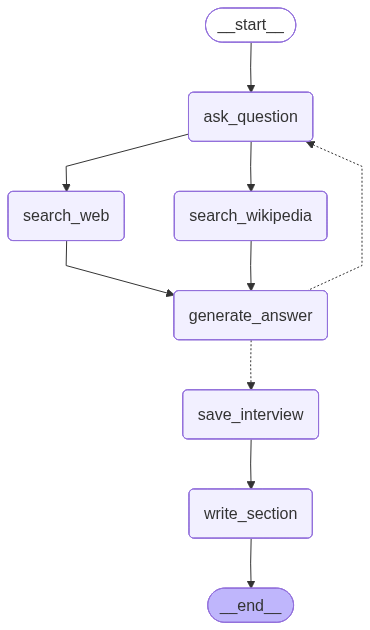

In [142]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [144]:
print(analyst.persona)

Name: Michael O'Connor
Role: Venture Capitalist
Affiliation: Cognitive Ventures
Expertise: Michael is a venture capitalist specializing in investments in AI and cognitive science start-ups. With a keen eye for innovative technologies, he has funded several successful companies in this space and provides strategic guidance to emerging start-ups focusing on AI applications in cognitive science.



In [145]:
thread = {"configurable": {"thread_id": "1"}}

In [146]:
from IPython.display import Markdown

In [147]:
messages = [HumanMessage("What are the bio-inspired AI products being developed?")]

In [148]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [149]:
Markdown(interview['sections'][0])

## Venture Capital Insights: AI and Cognitive Science Start-ups

### Summary

In the rapidly evolving landscape of artificial intelligence (AI) and cognitive science, venture capitalists like Michael are keenly focused on identifying and nurturing innovative technologies that promise to redefine human-computer interaction. The intersection of AI and cognitive science is particularly fertile ground for breakthroughs, as it combines the computational prowess of AI with insights into human cognition, potentially leading to the development of human-level artificial intelligence.

One of the most intriguing developments in this space is the emergence of biologically-inspired cognitive architectures (BICAAI) and their comparison with generative pre-trained transformers (GPT) [1]. While GPT-based products have gained significant traction due to their ability to mimic human conversation, they are not without their limitations and potential risks. BICAAI, on the other hand, aims to model the human mind more comprehensively, offering a different approach to achieving human-level AI.

Another exciting area is the development of bio-inspired analog computing, as exemplified by Unconventional AI. This start-up, founded by Naveen Rao, focuses on creating AI chips that draw on the energy efficiency principles of the human brain, offering a theoretical energy efficiency 1000 times greater than traditional GPUs [2]. This approach not only promises significant advancements in AI hardware but also highlights the potential for a paradigm shift in computing.

Furthermore, the concept of AI increasing human agency is gaining traction. Companies like AE Studios are building AI products that empower users, enhancing their ability to make decisions and perform tasks more effectively [3]. This philosophy aligns with the broader trend of AI being used to augment human capabilities rather than replace them.

In addition to these technological advancements, the AI market in India is experiencing rapid growth, driven by both start-ups and government initiatives. The market is projected to reach $8 billion by 2025, with significant contributions from generative AI models and applications in various sectors such as healthcare, finance, and education [4]. This growth underscores the global nature of AI innovation and the diverse opportunities it presents for venture capitalists.

Overall, the convergence of AI and cognitive science is paving the way for groundbreaking innovations that could transform industries and redefine human-computer interaction. For venture capitalists like Michael, this presents a unique opportunity to invest in technologies that not only promise financial returns but also have the potential to make a profound impact on society.

### Sources
[1] https://biomedres.us/pdfs/BJSTR.MS.ID.009461.pdf  
[2] https://eu.36kr.com/en/p/3659033412887429  
[3] https://www.cognitiverevolution.ai/biologically-inspired-ai-alignment-exploring-neglected-approaches-with-ae-studios-judd-and-mike/  
[4] https://en.wikipedia.org/wiki/Artificial_intelligence_in_India  

### Third Workflow

In [202]:
class ResearchGraphState(TypedDict):
    topic: str #Research topic
    max_analysts: int #Number of analysts to generate
    human_analyst_feedback: str #Feedback from human analyst to guide analyst generation
    analysts: List[Analyst] #List of generated analysts
    sections: Annotated[list, operator.add] #Send() API Key
    introduction: str #Introduction for the final report
    content: str #content for the final report
    conclusion: str #conclusion for the final report
    final_report: str #final report 

In [203]:
from langgraph.types import Send

In [204]:
def initiate_all_interviews(state: ResearchGraphState):
    """
    MAP step where we run each interview sub-graph using Send API.
    """
    #check for human feedback
    human_analyst_feedback = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        #if feedback exists, we need to regenerate analysts before running interviews
        return "create_analysts"

    #otherwise 
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst, 
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?")]}) 
                for analyst in state["analysts"]]
        

In [205]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

In [206]:
def write_report(state: ResearchGraphState):
    #Full set of sections
    sections = state["sections"]
    topic = state["topic"]
    
    #concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    #Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic = topic,
                                                       context = formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based on these memos.")])
    return {"content": report.content}

In [207]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


In [208]:
def write_introduction(state: ResearchGraphState):
    #Full set of sections
    topic = state["topic"]
    sections = state["sections"]
    #concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content="Write the introduction section of the report.")])
    
    return {"introduction": intro.content}

In [209]:
def write_conclusion(state: ResearchGraphState):
    #Full set of sections
    topic = state["topic"]
    sections = state["sections"]
    #concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content="Write the conclusion section of the report.")])
    
    return {"conclusion": conclusion.content}

In [210]:
def finalize_report(state: ResearchGraphState):
    """
    Finalize the report by combining the introduction, content, and conclusion into a single final report.
    """
    
    #save the full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None
    
    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [211]:
#Add nodes and edges
builder = StateGraph(ResearchGraphState)

builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

#Logic flow
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback",
                              initiate_all_interviews,
                              ["create_analysts",
                               "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_report", "write_introduction", "write_conclusion"], "finalize_report")
builder.add_edge("finalize_report", END)

In [212]:
memory = MemorySaver()

In [213]:
graph = builder.compile(interrupt_before = ['human_feedback'],checkpointer = memory)

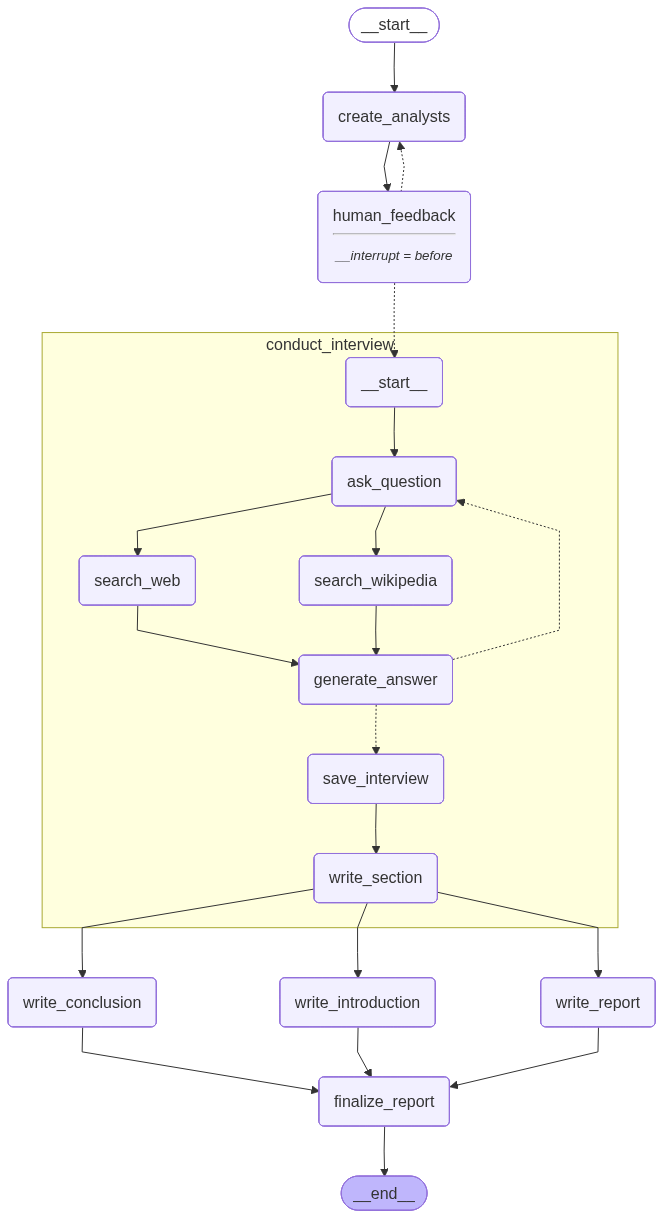

In [214]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [215]:
max_analysts = 3

In [216]:
topic = "The realistic impact of AI in education of people with autism"

In [217]:
thread = {"configurable": {"thread_id": "1"}}

In [218]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("-"*50)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Role: Educational Psychologist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen specializes in the intersection of technology and special education. Her research focuses on how AI can be leveraged to create personalized learning experiences for students with autism, enhancing their engagement and learning outcomes.

--------------------------------------------------
Name: Rajesh Kumar
Role: AI Developer
Affiliation: Tech for Inclusion
Expertise: Rajesh is an AI developer with a focus on creating accessible technology solutions. He works at Tech for Inclusion, a non-profit organization dedicated to developing AI tools that support individuals with disabilities, including those with autism, in educational settings.

--------------------------------------------------
Name: Sofia Martinez
Role: Special Education Advocate
Affiliation: Autism Speaks
Expertise: Sofia is an advocate for individuals with autism and works with Autism Speaks to promote incl

In [219]:
graph.update_state(thread, {"human_analyst_feedback":"Focus on human computer interaction specialist or specialist on cognitive science"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f109c96-0099-6ed5-8002-3106bd5fff96'}}

In [220]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("-"*50)

Name: Dr. Emily Chen
Role: Educational Psychologist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen specializes in the intersection of technology and special education. Her research focuses on how AI can be leveraged to create personalized learning experiences for students with autism, enhancing their engagement and learning outcomes.

--------------------------------------------------
Name: Rajesh Kumar
Role: AI Developer
Affiliation: Tech for Inclusion
Expertise: Rajesh is an AI developer with a focus on creating accessible technology solutions. He works at Tech for Inclusion, a non-profit organization dedicated to developing AI tools that support individuals with disabilities, including those with autism, in educational settings.

--------------------------------------------------
Name: Sofia Martinez
Role: Special Education Advocate
Affiliation: Autism Speaks
Expertise: Sofia is an advocate for individuals with autism and works with Autism Speaks to promote incl

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Role: Human-Computer Interaction Specialist
Affiliation: MIT Media Lab
Expertise: Dr. Emily Chen is a leading researcher in the field of human-computer interaction, focusing on adaptive technologies for individuals with cognitive disabilities. Her work at MIT Media Lab involves designing user-centered interfaces that enhance learning experiences for people with autism.

--------------------------------------------------
Name: Dr. Rajiv Patel
Role: Cognitive Scientist
Affiliation: Stanford University
Expertise: Dr. Rajiv Patel is a cognitive scientist specializing in neurodiversity and learning processes in individuals with autism. His research at Stanford University explores how AI can be leveraged to support personalized education strategies that cater to the unique cognitive profiles of autistic learners.

--------------------------------------------------
Name: Dr. Sarah Thompson
Role: Educational Technologist
Affiliation: University of Toronto
Expertise: Dr. Sa

In [221]:
graph.update_state(thread, {"human_analyst_feedback":""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f109c96-b1cd-664e-8006-5cd097e621c0'}}

In [222]:
graph.get_state(thread).next

('conduct_interview', 'conduct_interview', 'conduct_interview')

In [223]:
#continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("---Node---")
    node_name = next(iter(event.keys()))
    print(node_name)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.co

---Node---
conduct_interview
---Node---
conduct_interview
---Node---
conduct_interview


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 5.516000 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 5.514000 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 5.726000 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 2.396000 seconds
Retrying request to /chat/completions in 2.406000 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
Retrying request to /chat/completions in 2.136000 seconds
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HT

---Node---
write_conclusion
---Node---
write_introduction


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---Node---
write_report
---Node---
finalize_report


In [224]:
final_state = graph.get_state(thread)

In [225]:
report = final_state.values.get('final_report')

In [226]:
Markdown(report)

# The Realistic Impact of AI in Education for People with Autism

## Introduction

The integration of artificial intelligence (AI) in education is transforming the learning landscape for individuals with autism, offering innovative solutions tailored to their unique needs. This report explores the role of adaptive technologies in enhancing learning experiences, highlighting Dr. Emily Chen's work on user-centered interfaces and Dr. Rajiv Patel's research on personalized education strategies. It delves into AI's potential to improve communication, social skills, and personalized learning through tools like Smartbox systems and platforms such as DreamBox. Additionally, it addresses the ethical considerations and challenges, emphasizing the need for responsible implementation to maximize AI's benefits in special education.

---



The integration of artificial intelligence (AI) in the education of individuals with autism is transforming learning experiences by offering personalized and adaptive solutions that cater to their unique needs. AI technologies are being utilized to analyze speech patterns, identify communication challenges, and recommend specific interventions, thereby allowing for the adaptation of learning plans to meet individual needs [1]. Tools like those developed by Smartbox systems use visual and auditory cues to enhance language and social skills, providing real-time feedback to educators and therapists [2]. This approach is instrumental in creating inclusive classrooms that adapt to diverse learning needs.

Virtual and augmented reality (VR/AR) technologies are also playing a crucial role by providing immersive environments for practicing social interactions and navigating complex scenarios, offering safe and controlled settings for autistic students to enhance their social skills [3]. AI-powered facial recognition technologies help educators better understand and respond to the emotional states of students with autism [3]. Platforms like DreamBox and Smart Sparrow employ real-time response analysis to adapt lessons to individual learning paces, ensuring that each student can master concepts at their own speed [4].

AI is enhancing educational interventions by providing detailed analytics on a child's progress, skill deficiencies, and areas for improvement. This data-driven approach allows for more personalized and effective intervention strategies, particularly in developing social skills [2]. The Dynamic Social Attention Model (DSAM) is an example of an AI-enhanced intervention that modulates the intensity of interventions based on a child's responsiveness [3]. AI tools like speech recognition software and emotion recognition systems aid in communication and understanding for non-verbal students with autism, enhancing their ability to learn and interact [4].

AI-driven gamification and adaptive learning systems, such as those developed in the EdQuestGPT project, address critical gaps in special education services by providing student-centered instruction and tracking student behavior data to analyze and respond to trigger behaviors [5]. AI tools are also being integrated into assistive technologies, such as mobile applications and social robots, to enhance communication and daily functioning for individuals with autism [3].

Despite the promising advancements, challenges such as algorithmic bias, data privacy concerns, screen dependency, and the need for teacher training must be addressed to ensure the effective implementation of AI tools [5][6]. Ensuring transparency in decision-making and obtaining explicit consent from individuals with autism and their caregivers are crucial steps in the ethical implementation of AI technologies [6]. Additionally, the potential for AI systems to perpetuate societal biases if not properly trained highlights the need for diverse and representative training datasets [7].

In conclusion, AI is a transformative tool in the education of individuals with autism, offering new pathways to improved communication, learning, and social development. By addressing the challenges and leveraging the potential of AI, educators and therapists can create more inclusive and effective learning environments that cater to the diverse needs of neurodivergent students.


---

## Conclusion

The integration of AI in education for individuals with autism is proving to be a transformative force, offering personalized and adaptive learning experiences that cater to their unique needs. Through the pioneering work of experts like Dr. Emily Chen, Dr. Rajiv Patel, and Dr. Sarah Thompson, AI technologies are enhancing communication, social skills, and personalized learning. Tools such as AI-driven speech and emotion recognition, VR/AR environments, and adaptive learning platforms are creating inclusive classrooms and supporting educators in delivering tailored interventions. However, challenges like algorithmic bias, data privacy, and ethical considerations must be addressed to ensure responsible implementation. By overcoming these hurdles, AI can continue to empower autistic learners, fostering both academic and social development.

## Sources
[1] https://eyeclick.com/resources/blog/22  
[2] https://online.ysu.edu/degrees/education/msed/sped-autism/artificial-intelligence-assistive-tech/  
[3] https://link.springer.com/article/10.1007/s43681-025-00824-3  
[4] https://www.littleraysaba.com/blog/technology-assisted-learning-for-autism  
[5] https://aace.org/review/ai-driven-interventions-for-teaching-students-with-autism-an-interview-with-aaron-jones/  
[6] https://pmc.ncbi.nlm.nih.gov/articles/PMC10817661/  
[7] https://www.tandfonline.com/doi/full/10.1080/17483107.2025.2579822